In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import pickle

In [2]:
# default plot style
plt.style.use('fivethirtyeight')
sns.set(rc={'axes.facecolor':'#ebebeb', 'figure.facecolor':'#ebebeb'})

# default pandas display options
pd.set_option('display.max_columns',100)

In [3]:
# read in dataset
df = pd.read_csv('180k_reviews.csv', index_col=False)

In [4]:
df.head()

,shop,address,review_title,review,review_date,rating,view_count,reviewer,no_review,reviewer_grade
0,樂湯雞麵館 (庇利金街),佐敦庇利金街61號地舖,人氣醉豬手！必食！,今日出去買月餅，經過見到食砂鍋雞嘅，真係好耐冇食，人唔算多，就坐低幫襯下。這裏每張枱都有隔版...,2020-09-07,4.2,54 瀏覽,shadowcblog,536,等級4.0
1,Burger Joys (君悅居),灣仔駱克道42-50號君悅居地下E舖,Happy American Meal,The place is not hard to locate as it is near ...,2016-08-18,3.6,154 瀏覽,charmaine728,252,等級4.0
2,肥姐小食店 Fei Jie,旺角登打士街55號地下4A號舖,一個字，爽,我一行經好景我一定買佢架墨魚，爽脆有口感，必食，生腸夠鮮，爽哧，紅腸也不能少、每次兩串，加埋...,2014-07-31,4.0,1054 瀏覽,kelly512,12,等級2.0
3,The Jockey,跑馬地黃泥涌道33號,Unexpectedly delicious food in a pub! =],不嬲鐘意四處試新野既我，今次揀左跑馬地的The Jockey 和朋友「飯聚」。餐廳位於馬場的...,2014-06-20,4.2,1991 瀏覽,王貓,76,等級3.0
4,Lockeroom Dining (朗晴坊),旺角砵蘭街215號朗晴坊8樓,欣賞餐廳心思 ⚽️迷·美食家都啱😋,如果你身邊有球迷，一定聽過呢間餐廳。已經不是第一次到這裡吃飯，但每次都覺得很滿足，因為無論佈...,2020-07-12,5.0,60 瀏覽,cinskyblue,287,等級4.0


## Data preprocessing & text cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   shop            180000 non-null  object 
 1   address         180000 non-null  object 
 2   review_title    180000 non-null  object 
 3   review          180000 non-null  object 
 4   review_date     179915 non-null  object 
 5   rating          180000 non-null  float64
 6   view_count      180000 non-null  object 
 7   reviewer        180000 non-null  object 
 8   no_review       180000 non-null  object 
 9   reviewer_grade  180000 non-null  object 
dtypes: float64(1), object(9)
memory usage: 13.7+ MB


In [6]:
# drop na
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# convert date string to datetime object
df.review_date = pd.to_datetime(df['review_date'], errors='coerce')

# convert rating string to numeric
df.rating = df.rating.astype(float)

# extract numeric view count
df.view_count = df.view_count.apply(lambda x: ''.join([i for i in x if i.isdigit()]))
df.view_count = pd.to_numeric(df.view_count, errors='coerce')

# convert review count to int
def review_count(review):
    if 'k' in review.lower():
        return float(review[:review.find('k')])*1000
    else:
        return float(''.join([i for i in review if i.isdigit()]))
        
df.no_review = df.no_review.apply(review_count)

# extract numeric reviewer grade
# grade 0 being non-member
df.reviewer_grade = df.reviewer_grade.str.replace('等級','').replace('(非會員)',0)
df.reviewer_grade = df.reviewer_grade.astype(float)


In [7]:
# remove all punctuations (including chinese punctuations) in a string
def remove_punctuation(string):
    chin_punc = '！？｡＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿_——｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏.'
    output = re.sub(r'[^\w\s]','',string)
    output = "".join([i for i in output if i not in chin_punc])
    return output


In [8]:
import emoji

# the use of emoji tells a lot about the sentiment of the reviewer
def encode_emoji(string, emoji_list=list(emoji.UNICODE_EMOJI['en'].keys())):
    for i in emoji_list:
        if i in string:
            string = string.replace(i, f' emoji_{emoji_list.index(i)} ')
    return string
     

In [9]:
# HK people tend to use both Eng & Chin in their conversation 
# we can't just loop over every character in the string to remove eng words
# need to split eng text from chin
def split_word(string): 
    regex = r"[\u4e00-\ufaff]|emoji+\_*[0-9]*|[0-9]+|[a-zA-Z]+\'*[a-z]*"
    matches = re.findall(regex, string, re.UNICODE)
    return matches


In [10]:
# packaging every text cleaning function together in one function
def preprocess(string):
    if not pd.isna(string):
        output = string.lower()
        output = remove_punctuation(output)
        output = encode_emoji(output)
        return output


# clean review title and review text
df['review_title_clean'] = df['review_title'].apply(preprocess) 
df['review_clean'] = df['review'].apply(preprocess)


## EDA

In [11]:
df.describe()

,rating,view_count,no_review,reviewer_grade
count,179915.000000,179915.000000,179915.000000,179915.000000
mean,3.074261,680.892405,232.576128,2.768452
std,1.085909,1495.675801,611.341139,1.272365
min,1.000000,0.000000,0.000000,0.000000
25%,2.200000,73.000000,5.000000,2.000000
50%,3.200000,262.000000,59.000000,3.000000
75%,4.000000,706.000000,200.000000,4.000000
max,5.000000,106789.000000,7000.000000,8.000000


### Review rating

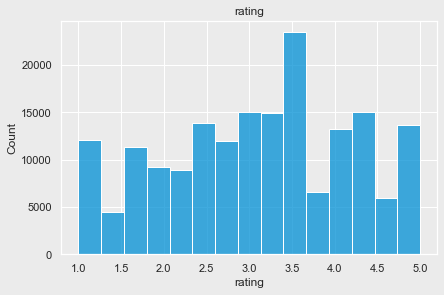

In [12]:
# rating 
sns.histplot(df['rating'],bins=15,color='#008fd5')
plt.title('rating')
plt.xlabel('rating')
plt.show()

In [13]:
# convert numerical rating scores into 3 classes - Negative, Neutral and Positive

def get_sentiment(rating):
    if rating <= 2.5:
        return 'Negative'
    elif 2.5<rating<=3.5:
        return 'Neutral'
    elif rating>3.5:
        return 'Positive'
        
df['sentiment'] = df['rating'].apply(get_sentiment)

/Users/Johnny/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


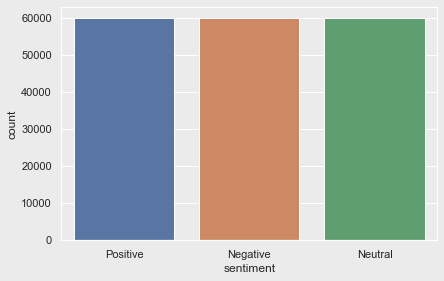

In [14]:
# plot
sns.countplot(df['sentiment'])
plt.show()

A significant portion of the reviewers are satisfied customers. People who are happy with their experience are more likely to leave a review than dissatisfied ones.

### Review view count

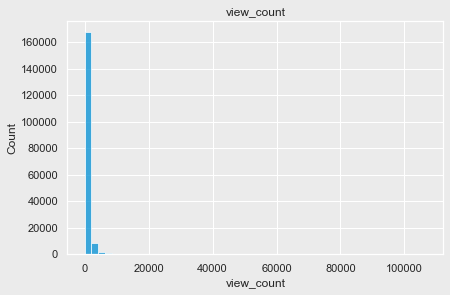

In [15]:
# view count per review 
sns.histplot(df['view_count'],bins=50,color='#008fd5')
plt.title('view_count')
plt.xlabel('view_count')
plt.show()

/Users/Johnny/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


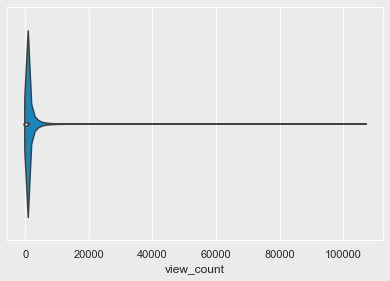

In [16]:
sns.violinplot(df['view_count'], color='#008fd5')
plt.show()

### Number of reviews per user

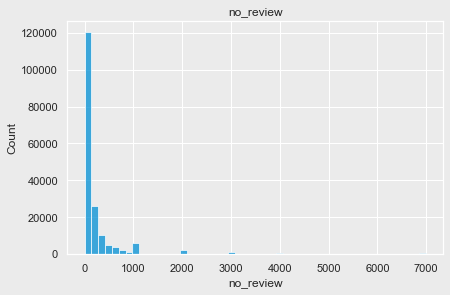

In [17]:
# review count per user 
sns.histplot(df['no_review'], bins=50, color='#008fd5') 
plt.title('no_review')
plt.xlabel('no_review')
plt.show()

In [18]:
# max review by user
df['no_review'].max()

7000.0

The craziest user has left 7,000 reviews!

### Title & review length

In [19]:
# title & review length -> number of chinese characters & english words
df['title_length'] = df['review_title'].apply(lambda x: len(split_word(x)))
df['review_length'] = df['review'].apply(lambda x: len(split_word(x)))

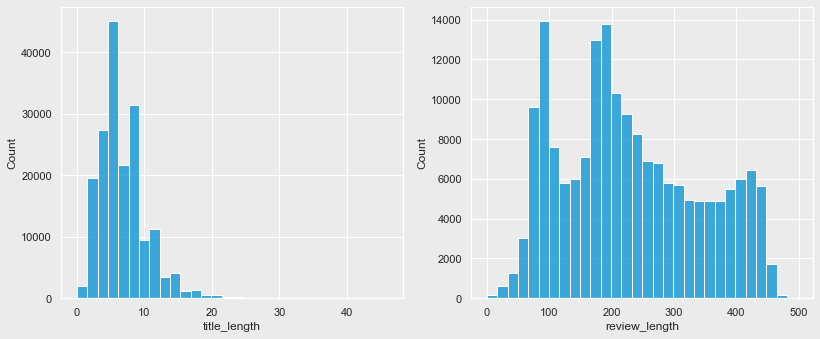

In [20]:
# title length 
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.histplot(df['title_length'], bins=30, color='#008fd5', ax=ax[0])
sns.histplot(df['review_length'], bins=30, color='#008fd5', ax=ax[1])
plt.show()

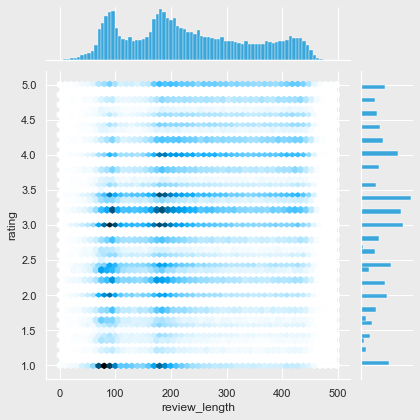

In [21]:
sns.jointplot(x=df['review_length'], y=df['rating'],kind="hex", color='#008fd5')
plt.show()


### Time distribution

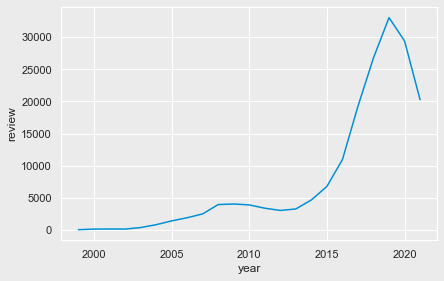

In [22]:
df['year'] = df['review_date'].apply(lambda x: x.year)
grouped = df.groupby('year').agg({'review':'count'})

# plot
sns.lineplot(x=grouped.index, y=grouped.review, color='#008fd5')
plt.show()

There is a noticeable drop in 2020, very likely due to the outbreak of the corona virus.

### Emoji usage
What are the pattern of usage of Emoji? Which Emojis are the most used?

In [23]:
# function to extract all emoji from text
def extract_emoji(text):
    if not pd.isna(text):
        split_text = emoji.get_emoji_regexp().split(text)
        emojis = [i for i in split_text if i in emoji.UNICODE_EMOJI['en']]
        return emojis

df['review_emoji'] = df['review'].apply(extract_emoji)

In [24]:
# get emoji count
df['review_emoji_count'] = df.review_emoji.apply(len)

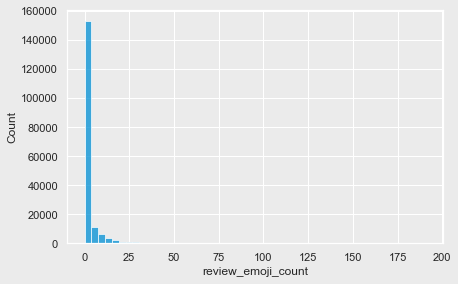

In [25]:
# plot
sns.histplot(df['review_emoji_count'],bins=50, color='#008fd5')
plt.show()


/Users/Johnny/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


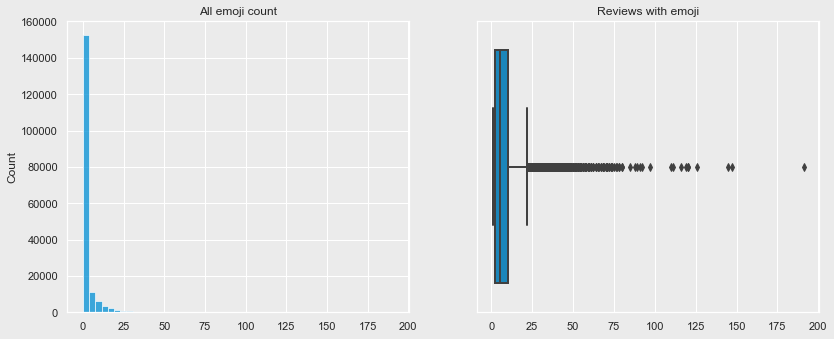

In [26]:
# emoji count given there's emoji in the review
emoji_count = df[df['review_emoji_count']>0]['review_emoji_count']

# plot
fig, ax = plt.subplots(1,2,figsize=(12,5), sharey=False)
sns.histplot(df['review_emoji_count'], bins=50, color='#008fd5', ax=ax[0]).set_title('All emoji count').set_x
ax[0].set_xlabel('')
sns.boxplot(emoji_count, color='#008fd5',linewidth=2, ax=ax[1]).set_title('Reviews with emoji')
ax[1].set_xlabel('')
plt.show()

Most reviews do not contain a single Emoji. And for the reviews that used Emoji, most only used a few of them. 

In [27]:
# most often-used emojis
all_emojis = [item for sublist in df['review_emoji'].to_list() for item in sublist]
top_emojis = pd.Series(all_emojis).value_counts().head(10).reset_index()
top_emojis.columns = ['emoji', 'count']

# visualize
top_emojis.style.bar(subset=['count'], color='#008fd5')


,emoji,count
0,😋,18150
1,👍🏻,16797
2,😂,14099
3,😍,11099
4,🤤,8577
5,⭐,8366
6,🤣,8331
7,👍,6950
8,😆,5380
9,😡,4859


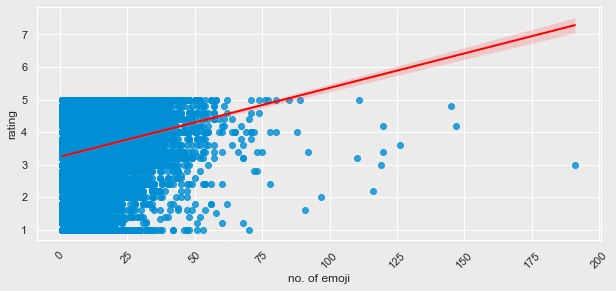

In [28]:
# how does the use of emoji relate to the rating?
plt.figure(figsize=(9,4))
sns.regplot(data=df[df['review_emoji_count'] > 0], x='review_emoji_count', y='rating', color='#008fd5', line_kws={"color": "red", "linewidth": 2})
plt.xticks(rotation=45)
plt.xlabel('no. of emoji')
plt.ylabel('rating')
plt.show()


Emoji is a direct way to convey the sentiment of the reviewer. Let's build a simple model to find the relative sentiment score of each emoji.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

df_emoji = df[df['review_emoji_count']>1]
corpus = [" ".join(i) for i in df_emoji['review_emoji'].to_list()]

# specify min document frequency for the vectorizer so that uncommon emojis are discarded
vectorizer = CountVectorizer(lowercase=False,analyzer = 'char',binary=True,min_df=100)
X = vectorizer.fit_transform(corpus)
y = df_emoji['rating'].values

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [31]:
emoji_importance = pd.DataFrame({'emoji': vectorizer.get_feature_names_out(),
                                 'coef': model.coef_}).sort_values('coef', ascending=False).reset_index(drop=True)

top_bot = emoji_importance.index[:5].to_list() + emoji_importance.index[-5:].to_list()
emoji_importance.iloc[top_bot]


,emoji,coef
0,🇵,0.740693
1,👍,0.301067
2,🎂,0.269522
3,😍,0.251292
4,🏮,0.251098
307,😠,-0.631728
308,👎,-0.691975
309,🤮,-0.743795
310,🤬,-0.844986
311,😡,-1.053077


The simple linear regression model is able to identify the general sentiment of emojis. The use of Emoji indeed tells a lot about the sentiment of a review. Instead of removing them like stop words, we should keep them for building the sentiment classfication model.

# Tokenize corpus
Next, we will tokenize the corpus for building the Word2Vec model later. Unlike the English language where words in a sentence are segmented by spaces, thereby allowing easy tokenization, the Chinese language and a lot of other languages are in fact not 'space-tokenizable', there is no space between words and phrases, a sentence is a string of unseparated characters. 

For tokenization of Chinese words, the most widely used tokenizer is Jieba. However, since there are fundamental differences in the use of vocabularies and style between the normal Chinese language, which Jieba handles, and Cantonese, we will use the Pycantonese library which is centered towards Cantonese NLP task to tokenize the corpus. 

In [32]:
import pycantonese

test_review = df['review_clean'][300]
tokens = pycantonese.segment(test_review)
" ".join(tokens)

'佐敦 新 開 左 間 隱 世 拉 麵 小店 主打 雞 白湯 拉 麵 同 鰻魚 飯 賣相 同 食物 都 似 座 銀 但 比較 下 呢 間 食落 更 有 驚喜 比 座 銀 更 勝 一 籌 雞 白湯 拉 麵 9855 同樣 有 黑 豚 慢煮 赤 雞 溏心蛋 同 炸 牛蒡 黑 豚 同 慢煮 雞 既 肉質 比 座 銀 更 軟 淋 雞 白湯 底 就 差不多 都 好 濃郁 溏心蛋 夠 流 心 價錢 較 平 性價比 高 火 炙 沖繩 阿 古 豬 飯 9835 去到 鰻魚 飯 賣 哂 唯有 試下 呢 款 期間 限定 供應 期 至 2011 阿 古 豬 質感 有啲 似 鴨 胸 如果 醬汁 多 啲 更 好 psdownload 餐廳 個 app 免費 送 溏心蛋 或 汔 水'

Off the shelf the segmenter is able to pick up most of the common vocabularies, however, it fails to capture a lot of the specific terms and phrases, e.g. the dish names, shop names, locations, etc.. To enhance the tokenization ability, we need to extract context-specific vocabularies from the corpus. The strategy:
1. group reviews by shop
2. use Gensim's Phrases class to extract context specific vocabularies (bi- & tri-grams)
3. add the vocabulary on top of the off-the-shelf segmenter

In [33]:
from gensim.models import Phrases

In [34]:
# grouped by shop name
grouped_shop = df.groupby('shop', as_index=False).agg({'review_clean':'unique','review':'count'})


# get context specific vocabularies related to the specific restaurant
def get_context_vocab(corpus, ngrams=3, min_review=40, min_count_percent=0.1, threshold=100):
    if len(corpus) >= min_review:
        corpus = [split_word(i) for i in corpus]
        for i in range(1,ngrams):
            ngram = Phrases(corpus, min_count=len(corpus)*min_count_percent, threshold=threshold, delimiter="")
            corpus = [ngram[sentence] for sentence in corpus]
        all_words = set([item for sublist in corpus for item in sublist])
        ngrams = [i for i in all_words if not i[0].isascii() and len(i) > 1]
        return ngrams


grouped_shop['context_specific_vocabs'] = grouped_shop['review_clean'].apply(lambda x: [re.sub(r'\bemoji_\d+\b','', str(i)) for i in x]).apply(get_context_vocab) # remove emoji encodings to avoid picking up phrases containing emojis


In [35]:
from pycantonese.word_segmentation import Segmenter

# all custom words
all_vocabs = [i for i in grouped_shop['context_specific_vocabs'].to_list() if i]
custom_words = set([item for sublist in all_vocabs for item in sublist])


# add the custom words to the segmenter
segmenter = Segmenter(allow=custom_words)
tokens = pycantonese.segment(test_review, cls=segmenter)
" ".join(tokens)

'佐敦 新 開 左 間 隱世 拉麵 小店 主打 雞 白湯 拉麵 同 鰻魚 飯 賣相 同 食物 都 似 座銀 但 比較 下 呢 間 食落 更 有 驚喜 比 座銀 更 勝 一 籌 雞 白湯 拉麵 9855 同樣 有 黑豚 慢煮 赤 雞 溏心蛋 同 炸 牛蒡 黑豚 同 慢煮 雞 既 肉質 比 座銀 更 軟 淋 雞 白湯 底 就 差不多 都 好 濃郁 溏心蛋 夠 流心 價錢 較 平 性價比 高 火炙 沖繩 阿古豬 飯 9835 去到 鰻魚 飯 賣 哂 唯有 試下 呢 款 期間 限定 供應 期 至 2011 阿古豬 質感 有啲 似 鴨胸 如果 醬汁 多 啲 更 好 psdownload 餐廳 個 app 免費 送 溏心蛋 或 汔 水'

In [36]:
# tokenize full corpus using the enhanced segmenter
def flatten(nested_list):
    return [i for sublist in nested_list for i in sublist]
    
df['full_tokens'] = df['review_clean'].apply(lambda x: [pycantonese.segment(i, cls=segmenter) for i in x.split()])
df['full_tokens'] = df['full_tokens'].apply(flatten)

In [37]:
# average no. of tokens
df['full_tokens'].apply(len).mean()

156.65565405886113

In [38]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as english_stopwords
import chinese_converter
import requests

# find chinese stopwords 
def get_chin_stopwords():
    stopwords_1 = list(pycantonese.stop_words())
    stopwords_2 = requests.get('https://raw.githubusercontent.com/stopwords-iso/stopwords-zh/master/stopwords-zh.json').json()
    # stopwords_2 in simplified chinese, need to translate to traditional chinese first
    stopwords_2 =  [chinese_converter.to_traditional(i) for i in stopwords_2]
    # combine the stopwords from the 2 sources
    chin_stopwords = stopwords_1 + stopwords_2
    return chin_stopwords

# get chinese & english stopwords
chin_stopwords = get_chin_stopwords()
eng_stopwords = english_stopwords.words('english')
all_stopwords = chin_stopwords + eng_stopwords


# function to remove stopwords
def remove_stopwords(tokens, stopword_list):
    output = [i for i in tokens if i not in stopword_list]
    return output


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Johnny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
# remove stop words
df['full_tokens'] = df['full_tokens'].apply(lambda x: remove_stopwords(x, all_stopwords))

## Word2Vec
The algorithm uses neural network to learn the word embeddings from the corpus. It convert tokens n-dimensional vectors which capture the latent semantic meaning and context of the words.

In [41]:
from gensim.models import Word2Vec

In [42]:
sentences = df['full_tokens']
embedding_dim = 300

# traing word2vec model
w2v_model = Word2Vec(min_count=10,  
                     window=5,  
                     vector_size=embedding_dim,  
                     workers=8)  

w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=100)
w2v_model.init_sims(replace=True)

In [43]:
# # save model
# with open('word2vec_model.pickle', 'wb') as f:
#     pickle.dump(w2v_model, f)
with open('word2vec_model.pickle', 'rb') as f:
    w2v_model = pickle.load(f)

In [44]:
# vocab size
vocab_size = len(w2v_model.wv.key_to_index)
print(vocab_size)

36635


Visualize 300 dimensional word embeddings in 2D

In [45]:
def top_similar_words(query_words, top=10):
    "Return a dictionary of top N similar words and their embedding vectors based on the input query word list."
    word_embeddings = {}
    for word in query_words:
        try:
            word_embeddings[word] = w2v_model.wv[word]
            similar_words = w2v_model.wv.most_similar(positive=[word])[:top]
            for similar, similarity in similar_words:
                word_embeddings[similar] = w2v_model.wv[similar]
        except:
            print(f'query word {word} not in the vocabulary.')
    return word_embeddings


In [46]:
query_words = ['朋友','尖沙咀','天氣','彈牙','酸','胡椒','四川','雞扒']

In [49]:
from translate import Translator
from sklearn.manifold import TSNE

# visualize 300-dimensional vectors in 2D using TSNE
word_embeddings = top_similar_words(query_words)
labels = list(word_embeddings.keys())
tokens = list(word_embeddings.values())

tsne_model = TSNE(perplexity=60, n_components=2, init='pca', n_iter=500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

# form a dataframe
tsne_df = pd.DataFrame(new_values, columns=['Component 1', 'Component 2'])
tsne_df['label'] = labels

# translate the Chinese to English - note that some translations maybe inaccurate due to local/slang terms
translator= Translator(to_lang="en",from_lang='zh')
# tsne_df['label_eng'] = tsne_df['label'].apply(lambda x: translator.translate(x))

/Users/Johnny/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/Johnny/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [50]:
tsne_df.head()

,Component 1,Component 2,label
0,1.521334,1.606653,朋友
1,1.477354,1.572478,友人
2,1.509402,1.646663,同事
3,1.576670,1.479228,朋友仔
4,1.451620,1.500583,男朋友


In [51]:
# plot
fig = px.scatter(tsne_df, x="Component 1", y="Component 2", text="label",
                 hover_name="label", hover_data=['label_eng'], width=700, height=400)

fig.update_traces(textposition='top center')
fig.layout.xaxis.autorange = True
fig.update_layout(title_text="Word2Vec Embeddings")
fig.show()


After training the word embeddings with Word2Vec, words of similar meanings and context are nicely clustered together.

## Model building

In [54]:
from sklearn.model_selection import train_test_split

# split training & testing data
X = df['full_tokens']
y = pd.get_dummies(df['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [55]:
def vectorize_data(corpus, model):
    """Map tokens to index of the corresponding vector"""
    get_token_index = lambda sentence: [model.wv.key_to_index[token] for token in sentence if str(token) in w2v_model.wv]
    vectors = list(map(get_token_index, corpus))
    return vectors


In [56]:
X_train = vectorize_data(X_train, w2v_model)
X_test = vectorize_data(X_test, w2v_model)


/Users/Johnny/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



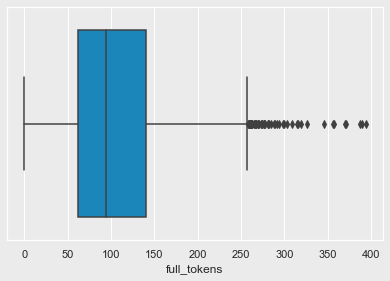

In [58]:
# distribution of tokenized corpus length 
sns.boxplot(df.full_tokens.apply(len), color='#008fd5')
plt.show()

In [59]:
df.full_tokens.apply(len).describe()

count    179915.000000
mean        102.225028
std          49.820916
min           0.000000
25%          62.000000
50%          94.000000
75%         140.000000
max         394.000000
Name: full_tokens, dtype: float64

Since neural networks take in a fixed size of input, we'll specify the input length. Inputs will be truncated or padded to match the input length.

In [60]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

input_length = 140
X_train = pad_sequences(X_train, maxlen=input_length)
X_test = pad_sequences(X_test, maxlen=input_length)


In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=300,
                    input_length=input_length,
                    weights=[w2v_model.wv.vectors],
                    trainable=False))
model.add(Bidirectional(LSTM(128, dropout=0.2)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.summary()


2022-02-21 01:27:06.154031: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-21 01:27:06.156882: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 300)          10990500  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
______________________________________________

In [62]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]


In [63]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.1, callbacks=callbacks)

In [64]:
# save model
model.save('model.h5')

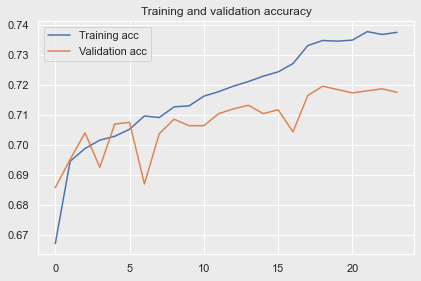

In [447]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

# training & validation accuracy
sns.lineplot(x=epochs, y=acc, label='Training acc')
sns.lineplot(x=epochs, y=val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.show()


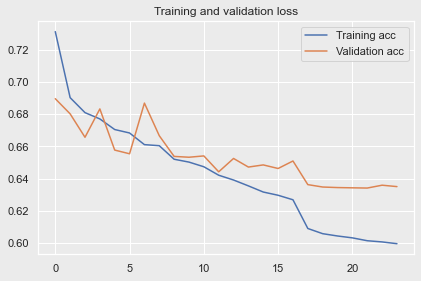

In [448]:
# training & validation loss
sns.lineplot(x=epochs, y=loss, label='Training acc')
sns.lineplot(x=epochs, y=val_loss, label='Validation acc')
plt.title('Training and validation loss')
plt.show()

In [66]:
from sklearn.metrics import accuracy_score
y_true = np.argmax(y_test.values, axis=1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# classification accuracy
accuracy_score(y_true, y_pred)

0.7207647843485994

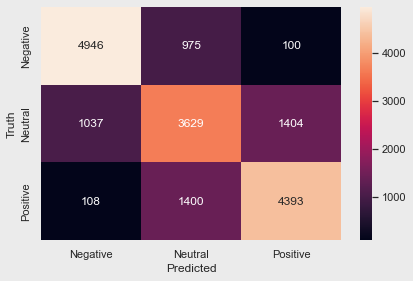

In [67]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_true, y_pred)
class_names = ['Negative', 'Neutral', 'Positive']
sns.heatmap(matrix, annot=True, xticklabels=class_names,yticklabels=class_names, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [68]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


              precision    recall  f1-score   support

    Negative       0.81      0.82      0.82      6021
     Neutral       0.60      0.60      0.60      6070
    Positive       0.74      0.74      0.74      5901

    accuracy                           0.72     17992
   macro avg       0.72      0.72      0.72     17992
weighted avg       0.72      0.72      0.72     17992

